In [1]:
import tensorflow as tf

/home/jacob/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [21]:
PATH_TO_CKPT =  './models/ssd300_vgg.pb' 

PATH_TO_LABELS = './models/crack_label_map.pbtxt'

NUM_CLASSES = 8

In [22]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [59]:
from utils import label_map_util

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


In [6]:
import numpy as np

def load_image_into_numpy_array(image):
    
    im_width, im_height = image.size
    
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [7]:
# Собираем наббор для тестирования

PATH_TO_TEST_IMAGES_DIR = '/home/jacob/workspace/RoadDamageDataset/'
D_TYPE = ['D00', 'D01', 'D10', 'D11', 'D20','D40', 'D43']
govs = ['Adachi', 'Ichihara', 'Muroran', 'Chiba', 'Sumida', 'Nagakute', 'Numazu']

val_list = []
for gov in govs:
    file = open(PATH_TO_TEST_IMAGES_DIR + gov + '/ImageSets/Main/val.txt', 'r')
    for line in file:
        line = line.rstrip('\n').split('/')[-1]
        val_list.append(line)
    file.close()

print("# of validation images：" + str(len(val_list)))

# of validation images：1813


In [8]:
import random
from PIL import Image
from utils import visualization_utils as vis_util
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

TEST_IMAGE_PATHS=[]

random.shuffle(val_list)

for val_image in val_list[0:5]:
    TEST_IMAGE_PATHS.append(PATH_TO_TEST_IMAGES_DIR + val_image.split('_')[0]+ '/JPEGImages/%s.jpg' %val_image)
IMAGE_SIZE = (12, 8)

In [9]:
TEST_IMAGE_PATHS

['/home/jacob/workspace/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908101237.jpg',
 '/home/jacob/workspace/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170908103553.jpg',
 '/home/jacob/workspace/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170912144633.jpg',
 '/home/jacob/workspace/RoadDamageDataset/Sumida/JPEGImages/Sumida_20170913151209.jpg',
 '/home/jacob/workspace/RoadDamageDataset/Muroran/JPEGImages/Muroran_20170905142913.jpg']

In [10]:
import os

test_img = ['/home/jacob/workspace/road_damage_detector/test_images/test_img.JPG']

(520, 780, 3)
boxes: (1, 100, 4), scores: (1, 100), class: (1, 100), num: (1,)
D44: 86%
D20: 37%
D20: 31%


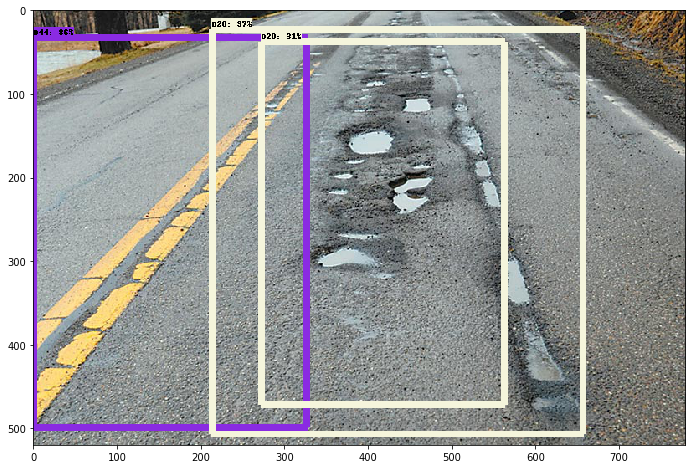

In [11]:
with detection_graph.as_default():
    
    with tf.Session(graph=detection_graph) as sess:
    
        # объявляем вхдные и выходные тензоры для графа
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Каждый бокс - часть изображения, где объекты уже обнаружены 
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # тензоры класса скоров
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for image_path in test_img:
            # Читаем картинку
            image = Image.open(image_path)
            
            # оборачиваем в нампи массив
            image_np = load_image_into_numpy_array(image)
            print (image_np.shape)
            # расширяем : [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            """
            Порог срабатывания по боксам оставить около 0.3 по скору
            
            """
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
#             print('boxes: {}, scores: {}, class: {}, num: {}'.format(boxes,scores,classes,num))
                        
            print('boxes: {}, scores: {}, class: {}, num: {}'.format(boxes.shape,scores.shape,classes.shape,num.shape))
                                                                     
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                min_score_thresh=0.3,
                use_normalized_coordinates=True,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            
            